![UCI](http://mlr.cs.umass.edu/ml/assets/logo.gif)

# Loading in the Data
In this example, we are going to use crossed columns and embedding columns inside of a tensorflow object created with the contrib "learn" library.

However, we will start the process by loading up a dataset with a mix of categorical data and numeric data. This dataset is quite old and has been used many times in machine learning examples: the census data from 1990's. We will use it to predict if a person will earn over or under 50k per year.

- https://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)

In [1]:
import pandas as pd

headers = ['age','workclass','fnlwgt','education','edu_num','marital_status',
           'occupation','relationship','race','sex','cap_gain','cap_loss','work_hrs_weekly','country','income']
df_train_orig = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',names=headers)
df_test_orig = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',names=headers)
df_test_orig = df_test_orig.iloc[1:]
print(df_train_orig.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age                32561 non-null int64
workclass          32561 non-null object
fnlwgt             32561 non-null int64
education          32561 non-null object
edu_num            32561 non-null int64
marital_status     32561 non-null object
occupation         32561 non-null object
relationship       32561 non-null object
race               32561 non-null object
sex                32561 non-null object
cap_gain           32561 non-null int64
cap_loss           32561 non-null int64
work_hrs_weekly    32561 non-null int64
country            32561 non-null object
income             32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None


In [7]:
from copy import deepcopy
df_train = deepcopy(df_train_orig)
df_test = deepcopy(df_test_orig)

The data is organized as follows: 

|Variable | description|
|----|--------|
|age: | continuous|
|workclass:      |Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, ...|
|fnlwgt:         |continuous.|
|education:      |Bachelors, Some-college, 11th, HS-grad, Prof-school, ...|
|education-num:  |continuous.|
|marital-status: |Married-civ-spouse, Divorced, Never-married, Separated, Widowed, ... |
|occupation:     |Tech-support, Craft-repair, Other-service, ...|
|relationship:   | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.|
|race:           |White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.|
|sex:            |Female, Male.|
|capital-gain:   |continuous.|
|capital-loss:   |continuous.|
|hours-per-week: |continuous.|
|native-country: |United-States, Cambodia, England, ... |
|**income (target):**|<50k, >=50k| 

In [8]:

import numpy as np

# let's just get rid of rows with any missing data
# and then reset the indices of the dataframe so it corresponds to row number
df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_test.head()

,age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,work_hrs_weekly,country,income
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
6,34,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K.


## Processing
For preprocessing, we are going to fix a few issues in the dataset. 

- This first includes the use of "50K." instead of "50K" in the test set. 
- Next, we will encode the categorical features as integers (later on we will encode one hot)
- Finally, we will make certain all the continuous data is scaled properly

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# replace strings
if df_test.income.dtype=='object':
    df_test.income.replace(to_replace=[' <=50K.',' >50K.'],value=['<=50K','>50K'],inplace=True)
    print(df_test.income.value_counts())

# define objects that can encode each variable as integer    
encoders = dict() 
categorical_headers = ['workclass','education','marital_status',
                       'occupation','relationship','race','sex','country']

# train all encoders (special case the target 'income')
for col in categorical_headers+['income']:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    
    if col=="income":
        tmp = LabelEncoder()
        df_train[col] = tmp.fit_transform(df_train[col])
        df_test[col] = tmp.transform(df_test[col])
    else:
        # integer encoded variables
        encoders[col] = LabelEncoder()
        df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
        df_test[col+'_int'] = encoders[col].transform(df_test[col])

# scale the numeric, continuous variables
numeric_headers = ["age", "cap_gain", "cap_loss","work_hrs_weekly"]

for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    
df_test.head()

<=50K    11360
>50K      3700
Name: income, dtype: int64


,age,workclass,fnlwgt,education,edu_num,marital_status,occupation,relationship,race,sex,...,country,income,workclass_int,education_int,marital_status_int,occupation_int,relationship_int,race_int,sex_int,country_int
1,-1.023104,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,...,United-States,0,2,1,4,6,3,2,1,38
2,-0.033340,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,...,United-States,0,2,11,2,4,0,4,1,38
3,-0.794697,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,...,United-States,1,1,7,2,10,0,4,1,38
4,0.423474,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,...,United-States,1,2,15,2,6,0,2,1,38
6,-0.337883,Private,198693.0,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,...,United-States,0,2,0,4,7,1,4,1,38


In [10]:
# let's start as simply as possible, without any feature preprocessing
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just scale all inputs
feature_columns = categorical_headers_ints+numeric_headers
X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

y_train = df_train['income'].values.astype(np.int)
y_test = df_test['income'].values.astype(np.int)

print(feature_columns)

['workclass_int', 'education_int', 'marital_status_int', 'occupation_int', 'relationship_int', 'race_int', 'sex_int', 'country_int', 'age', 'cap_gain', 'cap_loss', 'work_hrs_weekly']


![keras](https://blog.keras.io/img/keras-tensorflow-logo.jpg)


# An example similar to Sklearn, Keras
- We will start with creating a model that is similar to what we have seen in scikit-learn. 
- Let's not worry about pre-processing the data right now. Let's just get familiar with Keras.

In [11]:
from sklearn import metrics as mt

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.models import Model

Using TensorFlow backend.


In [13]:
# combine the features into a single large matrix
X_train = df_train[feature_columns].values
X_test = df_test[feature_columns].values

# This returns a tensor
inputs = Input(shape=(X_train.shape[1],))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=10, activation='relu')(inputs)
predictions = Dense(1,activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

___
## Adding more customization
For this particular optimization, we could go beyond SGD and use a different optimizer. There are many excellent explanations of different optimizers, for instance:
- http://sebastianruder.com/optimizing-gradient-descent/

Now that we have defined the model, its as simple as using it in a very familiar syntax:

In [14]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                130       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 141.0
Trainable params: 141.0
Non-trainable params: 0.0
_________________________________________________________________


In [15]:
%%time

model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=0)

from sklearn import metrics as mt
yhat = np.round(model.predict(X_test))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[11226   134]
 [ 3100   600]] 0.785258964143
CPU times: user 9.71 s, sys: 3.46 s, total: 13.2 s
Wall time: 8.83 s


Great! But we are not handling categorical data properly here... Let's fix that.

## One Hot Encoding Categorical Data
In order to add one-hot encoding, we need to convert the different columns into sparse arrays. To start, let's only create a model from the one hot encoded variables. 

In [16]:
# but we were dealing with the data incorrectly because we didn't one hot encode the 
#   categorical features
from sklearn.preprocessing import OneHotEncoder

# now let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

# the ohe instance will help us to organize our encoded matrix
print(ohe.feature_indices_)
print(X_train_ohe.shape)
print(type(X_train_ohe), '========THIS IS SPARSE ENCODED=======')

[ 0  7 23 30 44 50 55 57 98]
(30162, 98)
<class 'scipy.sparse.csr.csr_matrix'> ========THIS IS SPARSE ENCODED=======


In [17]:
# This returns a tensor
# the input can only be a scipy.sparse array
inputs = Input(shape=(X_train_ohe.shape[1],), sparse=True)

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=10, activation='relu')(inputs)
predictions = Dense(1,activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_train_ohe,y_train, epochs=10, batch_size=50, verbose=0)

# test on the data
yhat = np.round(model.predict(X_test_ohe))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10550   810]
 [ 2038  1662]] 0.810889774236


## Multi-Modal Networks: Combine Branches, Sparse and Dense
The keras functional API allows us to setup different branches of inputs. When we call the `fit` function, we can tell keras the input to each branch using a simple list (you can also use a dictionary to be more explicit).

- Lets create two matrics: 
 - one with the one-hot encoded data, `X_train_ohe`
 - and another with the numeric data, `X_train_num`

In [25]:
# combine the features with two branches

# let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

# and save off the numeric features
X_train_num =  df_train[numeric_headers].values
X_test_num = df_test[numeric_headers].values

# create sparse input branch for ohe
inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
xSparse = Dense(units=10, activation='relu', name='ohe_1')(inputsSparse)

# create dense input branch for numeric
inputsDense = Input(shape=(X_train_num.shape[1],),sparse=False, name='X_Numeric')
xDense = Dense(units=10, activation='relu',name='num_1')(inputsDense)

x = concatenate([xSparse, xDense], name='concat')
predictions = Dense(1,activation='sigmoid', name='combined')(x)

# This creates a model that includes
# the Input layer and Dense layers
model = Model(inputs=[inputsSparse,inputsDense], outputs=predictions)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
X_ohe (InputLayer)               (None, 98)            0                                            
____________________________________________________________________________________________________
X_Numeric (InputLayer)           (None, 4)             0                                            
____________________________________________________________________________________________________
ohe_1 (Dense)                    (None, 10)            990                                          
____________________________________________________________________________________________________
num_1 (Dense)                    (None, 10)            50                                           
___________________________________________________________________________________________

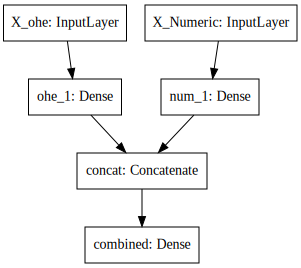

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [26]:
%%time

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit([ X_train_ohe, X_train_num ], # inputs for each branch are a list
          y_train, 
          epochs=10, 
          batch_size=50, 
          verbose=0)

yhat = model.predict([X_test_ohe,
                      X_test_num]) # each branch has an input

yhat = np.round(yhat)
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10594   766]
 [ 1769  1931]] 0.831673306773
CPU times: user 15.4 s, sys: 4.73 s, total: 20.1 s
Wall time: 14.4 s


So the confusion matrix is doing pretty well! But we still are just using an MLP with one hidden layer. We really want to take advantage of the embeddings and crossed columns that are possible with tensorflow. 


** [Back to Slides] **
___

# Crossed Columns and Deep Embeddings
Lets create the network below in steps. This network consists of a number of different paths for the input data to take.
![asdfasfd](https://www.tensorflow.org/images/wide_n_deep.svg)

## Step One: Using Dense embeddings 
First let's try a deeper architecture with dense embeddings for the categorical features, as described in lecture.

- The first decision to make is about the size of the dense feature embeddings. This is essentially a dimensionality reduction step. 
 - This can be difficult to set, but one common setting is $log_2(N)$ or $\sqrt{N}$ where $N$ is the total number of uniques values.
- When using an Embedding, we can leave the variables represented as integers. That is, keras will use the integer representation to figure out how to one-hot-encode the variable. This is great because it means we don't need to change the variable in memory. 

In [31]:
# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append( inputs )
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)

# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False, name='numeric'))
x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_branch_outputs.append( Dense(units=10,activation='relu', name='numeric_2')(x) )

# merge the branches together
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)


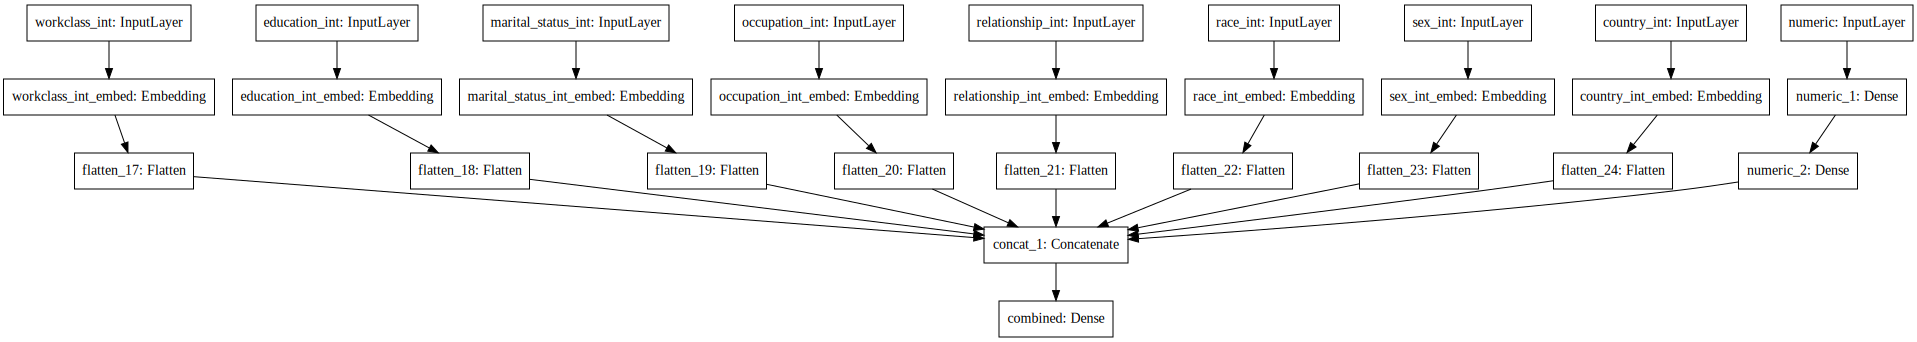

In [32]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [33]:
%%time

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_ints_train + [X_train_num], # create a list of inputs for embeddings
        y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
30162/30162 [==============================] - 4s - loss: 0.1811 - acc: 0.7528     
Epoch 2/10
30162/30162 [==============================] - 4s - loss: 0.1563 - acc: 0.7678     
Epoch 3/10
30162/30162 [==============================] - 4s - loss: 0.1471 - acc: 0.7803     
Epoch 4/10
30162/30162 [==============================] - 4s - loss: 0.1395 - acc: 0.7942     
Epoch 5/10
30162/30162 [==============================] - 4s - loss: 0.1328 - acc: 0.8058     
Epoch 6/10
30162/30162 [==============================] - 4s - loss: 0.1272 - acc: 0.8159     
Epoch 7/10
30162/30162 [==============================] - 4s - loss: 0.1229 - acc: 0.8237     
Epoch 8/10
30162/30162 [==============================] - 4s - loss: 0.1196 - acc: 0.8296     
Epoch 9/10
30162/30162 [==============================] - 4s - loss: 0.1172 - acc: 0.8333     
Epoch 10/10
30162/30162 [==============================] - 4s - loss: 0.1155 - acc: 0.8359     
CPU times: user 40.5 s, sys: 23.1 s, total: 1min 

In [34]:
yhat = np.round(model.predict(X_ints_test + [X_test_num]))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10729   631]
 [ 1824  1876]] 0.836985391766


That works fairly well using the embeddings. Now let's try to perform the same thing with crossed embeddings.


___


## Step Two: Making Crossed Columns
For this example, we are going to make embeddings for crossed columns. We will perform this step using `sklearn` 

Let's start simple with 
- just a single layer classifier 
- with branches of crossed categorical features as input 
 - one branch for each crossed column

In [35]:
cross_columns = [['education','occupation'],
                 ['country', 'occupation']]

# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for cols in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    
    # 3. save encodings in a list for each branch
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories in the crossing
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the crossed encoding
    inputs = Input(shape=(1,),dtype='int32',name='_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name='_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# merge the branches together
final_branch = concatenate(all_branch_outputs)
# add a layer after merging
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

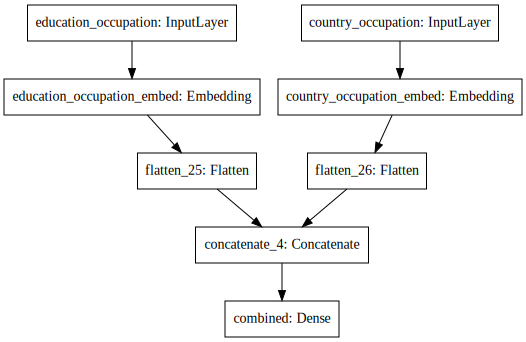

In [36]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [37]:
%%time

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_ints_train,
        y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
30162/30162 [==============================] - 2s - loss: 0.2069 - acc: 0.7438     
Epoch 2/10
30162/30162 [==============================] - 1s - loss: 0.1822 - acc: 0.7511     
Epoch 3/10
30162/30162 [==============================] - 1s - loss: 0.1766 - acc: 0.7511     
Epoch 4/10
30162/30162 [==============================] - 1s - loss: 0.1732 - acc: 0.7511     
Epoch 5/10
30162/30162 [==============================] - 1s - loss: 0.1707 - acc: 0.7511     
Epoch 6/10
30162/30162 [==============================] - 1s - loss: 0.1688 - acc: 0.7511     
Epoch 7/10
30162/30162 [==============================] - -22s - loss: 0.1674 - acc: 0.7511   
Epoch 8/10
30162/30162 [==============================] - 1s - loss: 0.1663 - acc: 0.7552     
Epoch 9/10
30162/30162 [==============================] - 1s - loss: 0.1654 - acc: 0.7599     
Epoch 10/10
30162/30162 [==============================] - 1s - loss: 0.1647 - acc: 0.7647     
CPU times: user 20.6 s, sys: 7.43 s, total: 28 s


In [38]:
yhat = np.round(model.predict(X_ints_test))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[10998   362]
 [ 3198   502]] 0.763612217795


Wow! That is just using crossed columns and a one layer Linear Classifer! So memorization works fairly well here.


___


## Step Three (Final): Combining Crossed Linear Classifier and Deep Embeddings
Now its just a matter of setting the wide and deep columns for tensorflow. After which, we can use the combined classifier!

Wide and deep models can have really interesting and useful properties so they are great to keep in mind when selecting an architecture. Some of the hyperparameters that are specific to this are:
- which features to cross together, typically you only want to cross columns you think are important to be connected--they somehow might create new knowledge by combining.
- the size of the dense feature embeddings. This can be difficult to set, but one common setting is $log_2(N)$ or $\sqrt{N}$ where $N$ is the total number of uniques values.

In [65]:
cross_columns = [['education','occupation'],
                 ['country', 'occupation'],
                 ['relationship','marital_status','sex'],
                 ['race','sex']]

#'workclass','education','marital_status','occupation','relationship','race','sex','country'

# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    # needs to be commented better, Eric!
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_branch_outputs, name='wide_concat')

# reset this input branch
all_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_branch_outputs.append( x )

# merge the branches together
deep_branch = concatenate(all_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)



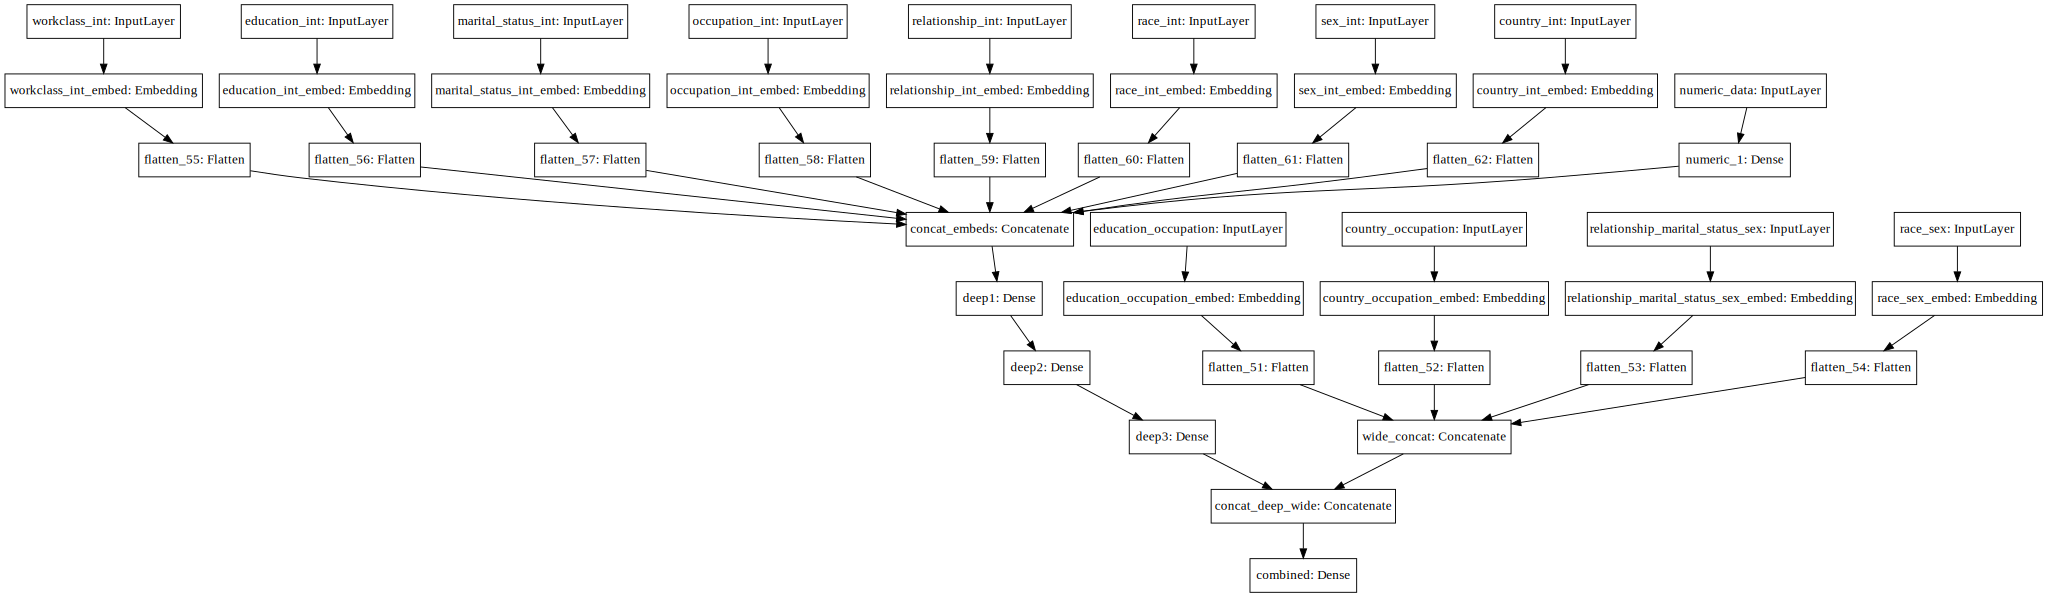

In [66]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [67]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])
# lets also add the history variable to see how we are doing
history = model.fit(X_ints_train+ [X_train_num],
                    y_train, 
                    epochs=10, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))

Train on 30162 samples, validate on 15060 samples
Epoch 1/10
30162/30162 [==============================] - 8s - loss: 0.1084 - acc: 0.8448 - val_loss: 0.1041 - val_acc: 0.8475
Epoch 2/10
30162/30162 [==============================] - 9s - loss: 0.1017 - acc: 0.8522 - val_loss: 0.1025 - val_acc: 0.8508
Epoch 3/10
30162/30162 [==============================] - 8s - loss: 0.1005 - acc: 0.8537 - val_loss: 0.1020 - val_acc: 0.8520
Epoch 4/10
30162/30162 [==============================] - 8s - loss: 0.0999 - acc: 0.8558 - val_loss: 0.1017 - val_acc: 0.8521
Epoch 5/10
30162/30162 [==============================] - 8s - loss: 0.0993 - acc: 0.8556 - val_loss: 0.1017 - val_acc: 0.8515
Epoch 6/10
30162/30162 [==============================] - 8s - loss: 0.0988 - acc: 0.8569 - val_loss: 0.1015 - val_acc: 0.8507
Epoch 7/10
30162/30162 [==============================] - 8s - loss: 0.0985 - acc: 0.8573 - val_loss: 0.1017 - val_acc: 0.8493
Epoch 8/10
30162/30162 [==============================] - 8s 

In [68]:
yhat = np.round(model.predict(X_ints_test + [X_test_num]))
print(mt.confusion_matrix(y_test,yhat), mt.accuracy_score(y_test,yhat))

[[10653   707]
 [ 1494  2206]] 0.85385126162


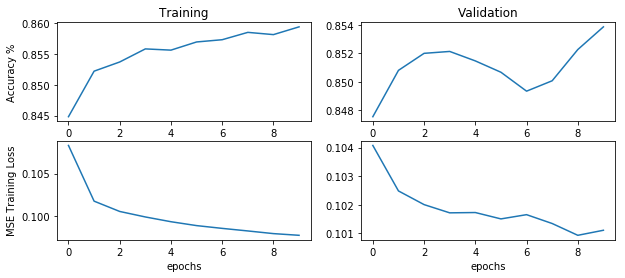

In [70]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])
plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')